In [18]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation
import plotly.express as px
import os


#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [2]:
schaefer_labels = load_parcellation('schaefer', scale=1000, join=True)

In [3]:
scz_path = 'clean_data/SCZ/schaefer1000'
controls_path = 'clean_data/controls/schaefer1000'

# Log Model on Gradients

## Get train & test data

In [4]:
scz_subjects = np.loadtxt('COBRE_SCZ_subjects.txt', dtype = str)
control_subjects = np.loadtxt('COBRE_controls_subjects.txt', dtype = str)

In [5]:
# train sample

scz_subjects_train = scz_subjects[:60]
control_subjects_train = control_subjects[:60]
subjects_train = np.concatenate((control_subjects_train, scz_subjects_train))

group_train = np.zeros(len(scz_subjects_train) + len(control_subjects_train))
group_train[:len(scz_subjects_train)] = 1
group_train = group_train.astype(bool)
data_train = np.stack((subjects_train, group_train))

In [6]:
data_train.shape

(2, 120)

In [7]:
# test sample 

scz_subjects_test = scz_subjects[60:]
control_subjects_test = control_subjects[60:]
subjects_test = np.concatenate((scz_subjects_test, control_subjects_test))

group_test = np.zeros(len(scz_subjects_test) + len(control_subjects_test))
group_test[:len(scz_subjects_test)] = 1
group_test = group_test.astype(bool)
data_test = np.stack((subjects_test, group_test))

In [8]:
data_test.shape

(2, 44)

In [9]:
subject_df_train = pd.DataFrame(data_train.T, columns = ['Subject', 'Group'])
subject_df_test = pd.DataFrame(data_test.T, columns = ['Subject', 'Group'])

In [10]:
# train grads
scz_grads_train = []
for subject in scz_subjects_train:
    grads = np.load(f'{scz_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')
    scz_grads_train.append(grads)
scz_grads_train = np.stack(scz_grads_train)

control_grads_train = []
for subject in control_subjects_train:
    grads = np.load(f'{controls_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')
    control_grads_train.append(grads)
control_grads_train = np.stack(control_grads_train)


In [11]:
# test grads
scz_grads_test = []
for subject in scz_subjects_test:
    grads = np.load(f'{scz_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')
    scz_grads_test.append(grads)
scz_grads_test = np.stack(scz_grads_test)

control_grads_test = []
for subject in control_subjects_test:
    grads = np.load(f'{controls_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')
    control_grads_test.append(grads)
control_grads_test = np.stack(control_grads_test)

In [12]:
train_grads = np.row_stack((scz_grads_train, control_grads_train))
test_grads = np.row_stack((scz_grads_test, control_grads_test))

In [13]:
train_grads.shape
test_grads.shape

(44, 1000, 10)

## Prepare Input

In [14]:
X_train_grads = train_grads[:, :, :6].reshape(train_grads.shape[0], -1)
y_train = subject_df_train['Group'].values

X_test_grads = test_grads[:, :, :6].reshape(test_grads.shape[0], -1)
y_test = subject_df_test['Group'].values


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train= le.fit_transform(y_train)
y_test= le.fit_transform(y_test)


## Train & Test Model on Gradients

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

perf_df_grads = pd.DataFrame(columns = ['N_grads', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC', 'Deviance'])

acc_list = []
prec_list = []
rec_list = []
f1_list = []
roc_auc_list = []
deviance_list = []

for n_grads in range(1, 11):
    X_train_grads = train_grads[:, :, :n_grads].reshape(train_grads.shape[0], -1)
    X_test_grads = test_grads[:, :, :n_grads].reshape(test_grads.shape[0], -1)

    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_train_grads, y_train)

    y_prob = clf.predict_proba(X_test_grads)
    y_pred = clf.predict(X_test_grads)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1)
    rec = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_prob[:, 1])

    log_likelihood_model = np.sum(y_test * np.log(y_prob[:, 1]) + (1 - y_test) * np.log(1 - y_prob[:, 1]))
    log_likelihood_saturated = np.sum(y_test * np.log(np.mean(y_test)) + (1 - y_test) * np.log(1 - np.mean(y_test)))
    deviance = -2 * (log_likelihood_model - log_likelihood_saturated)

    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    deviance_list.append(deviance)

perf_df_grads['N_grads'] = np.arange(1, 11)
perf_df_grads['Accuracy'] = acc_list
perf_df_grads['Precision'] = prec_list
perf_df_grads['Recall'] = rec_list
perf_df_grads['F1'] = f1_list
perf_df_grads['ROC_AUC'] = roc_auc_list
perf_df_grads['Deviance'] = deviance_list



# COBRE: Schizophrenia

In [16]:
perf_df_grads

N_grads  Accuracy  Precision    Recall        F1   ROC_AUC   Deviance
0        1  0.568182   0.392857  0.846154  0.536585  0.746898  65.063652
1        2  0.613636   0.423077  0.846154  0.564103  0.761787  42.160607
2        3  0.636364   0.434783  0.769231  0.555556  0.719603  46.007221
3        4  0.613636   0.416667  0.769231  0.540541  0.741935  46.019495
4        5  0.613636   0.416667  0.769231  0.540541  0.756824  41.939504
5        6  0.659091   0.458333  0.846154  0.594595  0.779156  39.102334
6        7  0.636364   0.440000  0.846154  0.578947  0.769231  39.975028
7        8  0.613636   0.423077  0.846154  0.564103  0.779156  36.247485
8        9  0.590909   0.400000  0.769231  0.526316  0.771712  34.725258
9       10  0.613636   0.423077  0.846154  0.564103  0.776675  34.621426

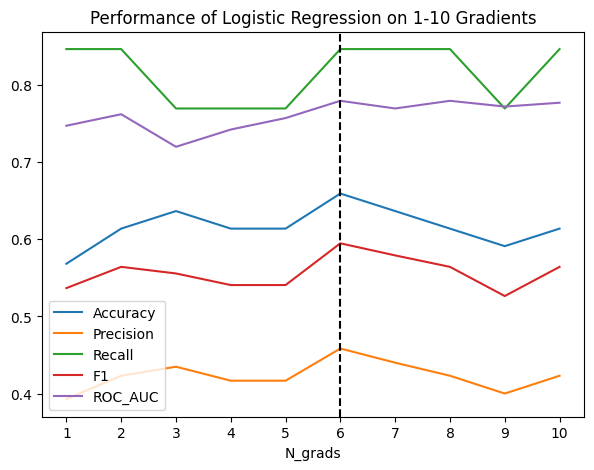

In [47]:
perf_df_grads.plot(x = 'N_grads', y = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'], figsize = (7, 5), title = 'Performance of Logistic Regression on 1-10 Gradients')
plt.xticks(perf_df_grads['N_grads'])
plt.axvline(perf_df_grads['N_grads'][(perf_df_grads['Accuracy'].idxmax() & perf_df_grads['Precision'].idxmax())], color = 'k', linestyle = '--')


# Log Model on Dispersion

In [23]:
n_neighbours_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]


In [24]:
# Compute dispersion

n_grads = 6
for n_neighbours in n_neighbours_list:
    for subject in scz_subjects:
        gradients = np.load(f'{scz_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')[:, :n_grads]
        hcp_ngbrs = NearestNeighbors(n_neighbors=n_neighbours, algorithm='brute').fit(gradients)
        distances, indices = hcp_ngbrs.kneighbors(gradients)
        subj_disp = distances.mean(axis = 1)
        np.save(f'{scz_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy', subj_disp)

    for subject in control_subjects:
        gradients = np.load(f'{controls_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')[:, :n_grads]
        hcp_ngbrs = NearestNeighbors(n_neighbors=n_neighbours, algorithm='brute').fit(gradients)
        distances, indices = hcp_ngbrs.kneighbors(gradients)
        subj_disp = distances.mean(axis = 1)
        np.save(f'{controls_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy', subj_disp)

## Prepare Disp Input

In [54]:
# load train & test dispersion in dicts

n_grads = 6
disp_dict_train = {}
disp_dict_test = {}

for n_neighbours in n_neighbours_list:
    disp_train = []
    for subject in scz_subjects_train:
        disp = np.load(f'{scz_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy')
        disp_train.append(disp)
    for subject in control_subjects_train:
        disp = np.load(f'{controls_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy')
        disp_train.append(disp)

    disp_train = np.stack(disp_train)
    disp_dict_train[n_neighbours] = disp_train

    disp_test = []
    for subject in scz_subjects_test:
        disp = np.load(f'{scz_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy')
        disp_test.append(disp)
    for subject in control_subjects_test:
        disp = np.load(f'{controls_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy')
        disp_test.append(disp)

    disp_test = np.stack(disp_test)
    disp_dict_test[n_neighbours] = disp_test
    


## Train & Test Model on Dispersion

In [26]:
perf_df_disp = pd.DataFrame(columns = ['N_neighbours', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC', 'Deviance'])

acc_list = []
prec_list = []
rec_list = []
f1_list = []
roc_auc_list = []
deviance_list = []

np.random.seed(0)

for n_neighbours in n_neighbours_list:
    X_train_disp = disp_dict_train[n_neighbours]
    X_test_disp = disp_dict_test[n_neighbours]

    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_train_disp, y_train)

    y_prob = clf.predict_proba(X_test_disp)
    y_pred = clf.predict(X_test_disp)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1)
    rec = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_prob[:, 1])

    log_likelihood_model = np.sum(y_test * np.log(y_prob[:, 1]) + (1 - y_test) * np.log(1 - y_prob[:, 1]))
    log_likelihood_saturated = np.sum(y_test * np.log(np.mean(y_test)) + (1 - y_test) * np.log(1 - np.mean(y_test)))
    deviance = -2 * (log_likelihood_model - log_likelihood_saturated)

    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    deviance_list.append(deviance)

perf_df_disp['N_neighbours'] = n_neighbours_list
perf_df_disp['Accuracy'] = acc_list
perf_df_disp['Precision'] = prec_list
perf_df_disp['Recall'] = rec_list
perf_df_disp['F1'] = f1_list
perf_df_disp['ROC_AUC'] = roc_auc_list
perf_df_disp['Deviance'] = deviance_list



In [76]:
perf_df_disp

N_neighbours  Accuracy  Precision    Recall        F1   ROC_AUC   Deviance
0              5  0.522727   0.277778  0.384615  0.322581  0.444169  12.252810
1             10  0.522727   0.277778  0.384615  0.322581  0.449132  14.018506
2             15  0.568182   0.312500  0.384615  0.344828  0.473945  13.498657
3             20  0.522727   0.250000  0.307692  0.275862  0.468983  13.510720
4             25  0.545455   0.294118  0.384615  0.333333  0.503722  13.081772
5             30  0.545455   0.294118  0.384615  0.333333  0.498759  12.560019
6             35  0.590909   0.352941  0.461538  0.400000  0.518610  11.916749
7             40  0.590909   0.352941  0.461538  0.400000  0.526055  11.308297
8             45  0.613636   0.375000  0.461538  0.413793  0.553350  10.753386
9             50  0.613636   0.375000  0.461538  0.413793  0.553350  10.199981
10            55  0.590909   0.352941  0.461538  0.400000  0.585608   9.618158
11            60  0.590909   0.352941  0.461538  0.400000  0.588089   9.165753
12            65  0.590909   0.368421  0.538462  0.437500  0.590571   8.763224
13            70  0.590909   0.368421  0.538462  0.437500  0.615385   8.280639
14            75  0.613636   0.388889  0.538462  0.451613  0.630273   7.816094
15            80  0.590909   0.368421  0.538462  0.437500  0.632754   7.418662
16            85  0.613636   0.388889  0.538462  0.451613  0.642680   7.108515
17            90  0.636364   0.421053  0.615385  0.500000  0.655087   6.832031
18            95  0.636364   0.421053  0.615385  0.500000  0.667494   6.556736
19           100  0.659091   0.450000  0.692308  0.545455  0.662531   6.305855
20           105  0.659091   0.450000  0.692308  0.545455  0.669975   6.101044
21           110  0.681818   0.476190  0.769231  0.588235  0.672457   5.916435
22           115  0.681818   0.476190  0.769231  0.588235  0.679901   5.766887
23           120  0.681818   0.476190  0.769231  0.588235  0.679901   5.667975

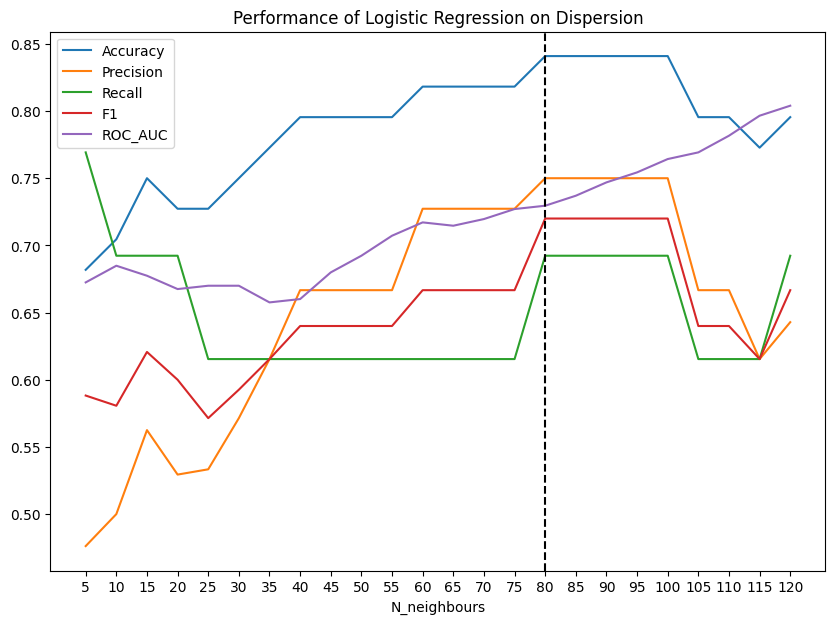

In [27]:
# plot performance of logistic regression on dispersion
perf_df_disp.plot(x = 'N_neighbours', y = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'], figsize = (10, 7), title = 'Performance of Logistic Regression on Dispersion')
# draw a vertical line where accuracy is maximum
#disply every level of n_neighbours on the x-axis
plt.xticks(perf_df_disp['N_neighbours'])
plt.axvline(perf_df_disp['N_neighbours'][perf_df_disp['Accuracy'].idxmax()], color = 'k', linestyle = '--')


## Permutation test to identify sig. regions

In [23]:
X_train_disp[:, 1].shape

(120,)

In [24]:
X_train_disp = disp_dict_train[80]
X_test_disp = disp_dict_test[80]

In [25]:
regions = np.arange(1, 1001)
np.savetxt("schaefer1000_regions.txt", regions, fmt = '%.0f')

In [26]:
import csv
region = 999

def perm_test_logreg(X_train, y_train, n_permutations=1000, region = region):
    # Initialize empty arrays to store beta coefficients and p-values for each region
    beta_coefficients = np.zeros(X_train.shape[1])
    
    # Fit a logistic regression model to the training data
    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_train, y_train)

    # Compute the beta coefficients for the logistic regression model
    beta_coefficients = clf.coef_[0]

    # Compute the p-values for the beta coefficients using a permutation test
    np.random.seed(0)

    permuted_feature = np.random.permutation(X_train[:, region])
    permuted_X_train = np.copy(X_train)
    permuted_X_train[:, region] = permuted_feature

    clf_permuted = LogisticRegression(max_iter=10000)
    clf_permuted.fit(permuted_X_train, y_train)

    beta_coefficients_permuted = clf_permuted.coef_[0][region]
    beta_diff = beta_coefficients_permuted - beta_coefficients[region]
    
    permuted_beta_diffs = np.zeros(n_permutations)
    for j in range(n_permutations):
        permuted_y_train = np.random.permutation(y_train)
        clf_permuted_y = LogisticRegression(max_iter=10000)
        clf_permuted_y.fit(permuted_X_train, permuted_y_train)
        permuted_beta_coefficients = clf_permuted_y.coef_[0][region]
        permuted_beta_diffs[j] = permuted_beta_coefficients - beta_coefficients[region]
    
    p_value = np.sum(np.abs(permuted_beta_diffs) >= np.abs(beta_diff)) / n_permutations
    with open('results/logreg_perm_test_res.csv', mode='a', newline='') as csv_file:
        fieldnames = ['p_value', "beta", 'region']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        if csv_file.tell() == 0:  # check if file is empty
            writer.writerow({'p_value': "p_value", "beta": "beta", 'region': "region"})
        writer.writerow({'p_value': p_value, 'beta': beta_coefficients[region], 'region': region + 1})

In [29]:
scz_group_grads = np.load(f'{scz_path}/aligned_schz_group_10grads_schaefer1000.npy')
control_group_grads = np.load(f'{controls_path}/aligned_control_group_10grads_schaefer1000.npy')

In [30]:
X_train_disp.shape
y_train.shape

(120,)

In [31]:
results = pd.read_csv('logreg_perm_test_res.csv')
results["Sig"] = False
results.loc[results["p_value"] <= 0.05, ["Sig"]]= True
results["Grad1_SCZ"] = scz_group_grads[:, 0]
results["Grad1_Control"] = control_group_grads[:, 0]
results["Grad2_SCZ"] = scz_group_grads[:, 1]
results["Grad2_Control"] = control_group_grads[:, 1]
results["Grad3_SCZ"] = scz_group_grads[:, 2]
results["Grad3_Control"] = control_group_grads[:, 2]


In [32]:
sig_df = results[results['Sig']].reset_index()

In [33]:
fig1 = px.scatter(results, x="Grad2_SCZ", y="Grad1_SCZ",
                  color='beta',template = "plotly_white", color_continuous_scale='Bluered', opacity=0.08)

fig1.update_layout(scene=dict(
                    xaxis=dict(
                         showbackground=True,
                         backgroundcolor='white',
                         gridcolor="rgb(220, 220, 220)",
                         zerolinecolor="white",
                         title="Gradient 2",
                         showticklabels=False),
                    yaxis=dict(
                        showbackground=True,
                        backgroundcolor='white',
                        gridcolor="rgb(220, 220, 220)",
                        zerolinecolor="white",
                        title="Gradient 1",
                        showticklabels=False)),
                    width=700,
                    height=500,
                    margin=dict(r=10, l=10, b=10, t=10))

fig2 = px.scatter(sig_df, x="Grad2_SCZ", y="Grad1_SCZ",
                  color='beta',template = "plotly_white", color_continuous_scale='Bluered', opacity=1.0)
fig1.add_trace(fig2.data[0])
fig1.show()


In [34]:
fig1 = px.scatter(results, x="Grad2_Control", y="Grad1_Control",
                  color='beta',template = "plotly_white", color_continuous_scale='Bluered', opacity=0.08)

fig1.update_layout(scene=dict(
                    xaxis=dict(
                         showbackground=True,
                         backgroundcolor='white',
                         gridcolor="rgb(220, 220, 220)",
                         zerolinecolor="white",
                         title="Gradient 2",
                         showticklabels=False),
                    yaxis=dict(
                        showbackground=True,
                        backgroundcolor='white',
                        gridcolor="rgb(220, 220, 220)",
                        zerolinecolor="white",
                        title="Gradient 1",
                        showticklabels=False)),
                    width=700,
                    height=500,
                    margin=dict(r=10, l=10, b=10, t=10))

fig2 = px.scatter(sig_df, x="Grad2_Control", y="Grad1_Control",
                  color='beta',template = "plotly_white", color_continuous_scale='Bluered', opacity=1.0)
fig1.add_trace(fig2.data[0])
fig1.show()

## Plot results on control 1st grad

In [35]:
sig_regions = results["Sig"].values

In [36]:
sig_region_effect = np.zeros((1000))
sig_region_effect[:] = np.nan
sig_region_effect[sig_regions == True]  = results["beta"].values[sig_regions == True]

In [37]:
results["beta"].values[sig_regions == True]

array([ 0.0383942 ,  0.00340695,  0.06374755, -0.04501805, -0.13135384,
       -0.03777134,  0.10963997, -0.14771635, -0.00614462, -0.38193085,
        0.09344675,  0.05582711, -0.04847695, -0.0895011 ,  0.14369879,
       -0.16801373, -0.19851753, -0.03097096, -0.01401264,  0.07944625,
       -0.13681568, -0.08712567, -0.15246304,  0.05453908, -0.07302381,
       -0.03585372,  0.03584319, -0.15945309, -0.28523935, -0.13340846,
        0.0075728 ,  0.2756622 , -0.21012307, -0.03597933])

In [38]:
sig_regions_vis = map_to_labels(sig_regions, schaefer_labels, mask=schaefer_labels != 0, fill=np.nan)
sig_region_effect_vis = map_to_labels(sig_region_effect, schaefer_labels, mask=schaefer_labels != 0, fill=np.nan)

In [39]:
control_1grad_aligned_vis = map_to_labels(control_group_grads[:, 0], schaefer_labels, mask=schaefer_labels != 0, fill=np.nan)

In [40]:
surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
lh_parc, rh_parc = load_parcellation('schaefer')

In [41]:
np.unique(sig_region_effect_vis*100)

array([-38.193085  , -28.52393538, -21.01230676, -19.85175308,
       -16.80137278, -15.94530933, -15.24630354, -14.77163457,
       -13.68156835, -13.34084619, -13.13538436,  -8.95010986,
        -8.71256666,  -7.30238121,  -4.84769514,  -4.50180474,
        -3.77713414,  -3.58537202,  -3.09709559,  -1.40126432,
        -0.61446245,   0.34069504,   0.75728011,   3.5843185 ,
         3.83942023,   5.45390771,   5.58271103,   6.37475461,
         7.94462463,   9.34467495,  10.96399736,  14.36987874,
        27.56622007,          nan])

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_4032/3150529044.py:7: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



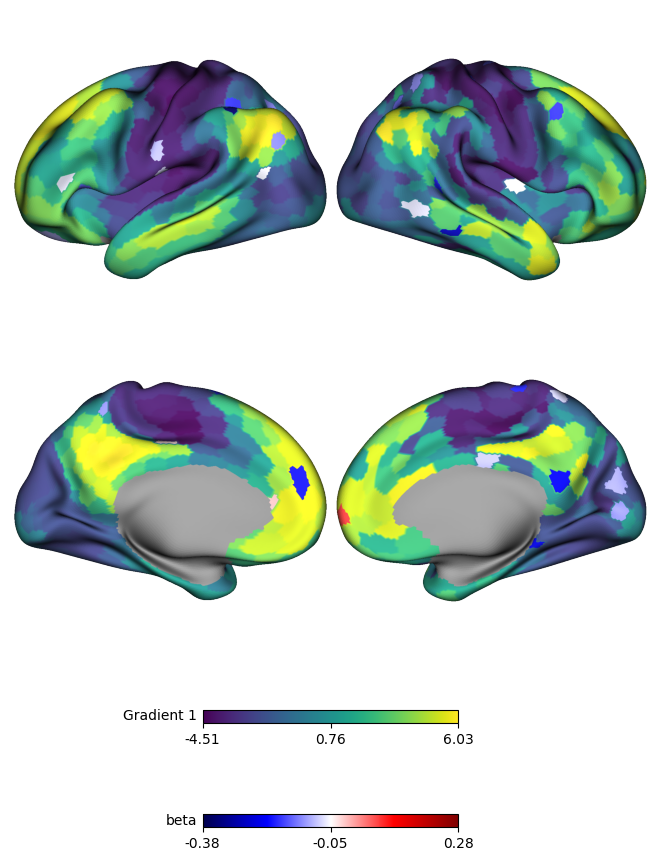

In [42]:
result_coefs = Plot(lh, rh,  size=(1000, 1000), zoom = 1.25)

result_coefs.add_layer({'left': control_1grad_aligned_vis[:32492], 'right': control_1grad_aligned_vis[32492:]}, cbar=True, cmap = "viridis", cbar_label= "Gradient 1")
result_coefs.add_layer({'left': sig_region_effect_vis[:32492]*10, 'right': sig_region_effect_vis[32492:]*10}, as_outline= False, cmap='seismic', cbar=True, cbar_label="beta", color_range = (np.nanmin(sig_region_effect_vis), np.nanmax(sig_region_effect_vis)))

fig = result_coefs.build(scale = (2, 2))
fig.show()
#result_t.show(embed_nb = True, scale=(10, 10))

## Train & Test Model on Sig Region Only

In [43]:
perf_df_disp = pd.DataFrame(columns = ['N_neighbours', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC', 'Deviance'])

acc_list = []
prec_list = []
rec_list = []
f1_list = []
roc_auc_list = []
deviance_list = []

np.random.seed(0)

for n_neighbours in n_neighbours_list:
    X_train_disp = disp_dict_train[n_neighbours][:, sig_regions]
    X_test_disp = disp_dict_test[n_neighbours][:, sig_regions]

    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_train_disp, y_train)

    y_prob = clf.predict_proba(X_test_disp)
    y_pred = clf.predict(X_test_disp)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1)
    rec = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_prob[:, 1])

    log_likelihood_model = np.sum(y_test * np.log(y_prob[:, 1]) + (1 - y_test) * np.log(1 - y_prob[:, 1]))
    log_likelihood_saturated = np.sum(y_test * np.log(np.mean(y_test)) + (1 - y_test) * np.log(1 - np.mean(y_test)))
    deviance = -2 * (log_likelihood_model - log_likelihood_saturated)

    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    deviance_list.append(deviance)

perf_df_disp['N_neighbours'] = n_neighbours_list
perf_df_disp['Accuracy'] = acc_list
perf_df_disp['Precision'] = prec_list
perf_df_disp['Recall'] = rec_list
perf_df_disp['F1'] = f1_list
perf_df_disp['ROC_AUC'] = roc_auc_list
perf_df_disp['Deviance'] = deviance_list

In [45]:
perf_df_grads

N_grads  Accuracy  Precision    Recall        F1   ROC_AUC   Deviance
0        1  0.568182   0.392857  0.846154  0.536585  0.746898  65.063652
1        2  0.613636   0.423077  0.846154  0.564103  0.761787  42.160607
2        3  0.636364   0.434783  0.769231  0.555556  0.719603  46.007221
3        4  0.613636   0.416667  0.769231  0.540541  0.741935  46.019495
4        5  0.613636   0.416667  0.769231  0.540541  0.756824  41.939504
5        6  0.659091   0.458333  0.846154  0.594595  0.779156  39.102334
6        7  0.636364   0.440000  0.846154  0.578947  0.769231  39.975028
7        8  0.613636   0.423077  0.846154  0.564103  0.779156  36.247485
8        9  0.590909   0.400000  0.769231  0.526316  0.771712  34.725258
9       10  0.613636   0.423077  0.846154  0.564103  0.776675  34.621426

### Recall = TP / (TP + FN)
### Precision = TP / (TP + FP)

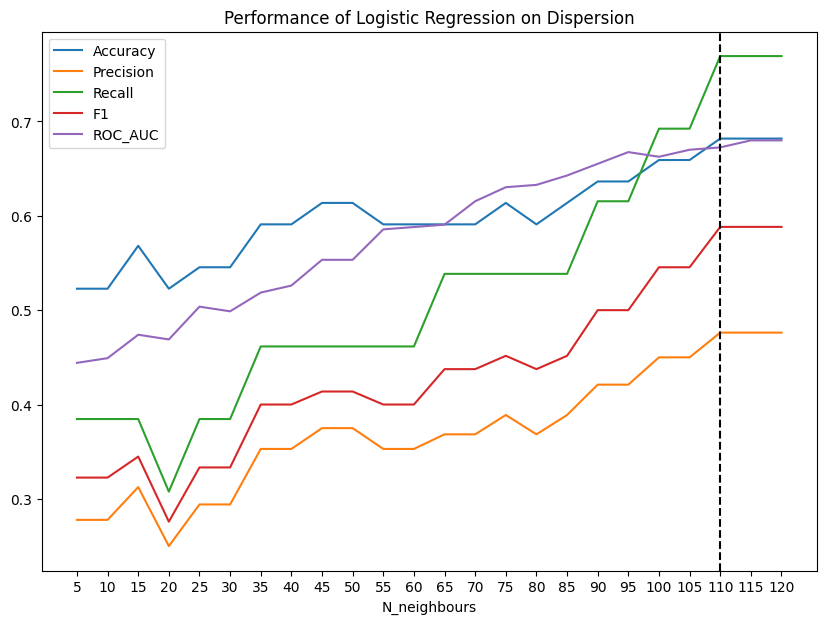

In [44]:
# plot performance of logistic regression on dispersion
perf_df_disp.plot(x = 'N_neighbours', y = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'], figsize = (10, 7), title = 'Performance of Logistic Regression on Dispersion')
# draw a vertical line where accuracy is maximum
#disply every level of n_neighbours on the x-axis
plt.xticks(perf_df_disp['N_neighbours'])
plt.axvline(perf_df_disp['N_neighbours'][perf_df_disp['Accuracy'].idxmax()], color = 'k', linestyle = '--')

# Model Fit + LOO CV

In [48]:
X_grads = np.row_stack([scz_grads_train, scz_grads_test, control_grads_train, control_grads_test])
y_grads = np.concatenate([np.ones(scz_grads_train.shape[0] + scz_grads_test.shape[0]), np.zeros(control_grads_train.shape[0] + control_grads_test.shape[0])]).astype(int)
y_grads

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## On Gradients

In [50]:
# fit model with LOO CV
from sklearn.model_selection import LeaveOneOut

perf_df_disp = pd.DataFrame(columns = ['N_grads', 'Accuracy', 'Precision', 'Recall', 'F1', 'Deviance'])
dfs = []

loo = LeaveOneOut()

for n_grads in range(1, 11):
    acc_list = []
    prec_list = []
    rec_list = []
    f1_list = []
    roc_auc_list = []
    deviance_list = []

    X_grad_sample = X_grads[:, :, :n_grads].reshape(X_grads.shape[0], -1)
    clf = LogisticRegression(max_iter=10000)

    for train_index, test_index in loo.split(X_grad_sample):
        X_train_disp, X_test_disp = X_grad_sample[train_index], X_grad_sample[test_index]
        y_train, y_test = y_grads[train_index], y_grads[test_index]

        clf.fit(X_train_disp, y_train)

        y_prob = clf.predict_proba(X_test_disp)
        y_pred = clf.predict(X_test_disp)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, pos_label=1)
        rec = recall_score(y_test, y_pred, pos_label=1)
        f1 = f1_score(y_test, y_pred, pos_label=1)
        #roc_auc = roc_auc_score(y_test, y_prob[:, 1])

        log_likelihood_model = np.sum(y_test * np.log(y_prob[:, 1]) + (1 - y_test) * np.log(1 - y_prob[:, 1]))
        log_likelihood_saturated = np.sum(y_test * np.log(np.mean(y_test)) + (1 - y_test) * np.log(1 - np.mean(y_test)))
        deviance = -2 * (log_likelihood_model - log_likelihood_saturated)

        acc_list.append(acc)
        prec_list.append(prec)
        rec_list.append(rec)
        f1_list.append(f1)
        #roc_auc_list.append(roc_auc)
        deviance_list.append(deviance)

    perf_df_grads_temp = pd.DataFrame({
        'N_grads': [n_grads] * len(y_grads),
        'Accuracy': acc_list,
        'Precision': prec_list,
        'Recall': rec_list,
        'F1': f1_list,
        #'ROC_AUC': roc_auc_list,
        'Deviance': deviance_list
    })

    dfs.append(perf_df_grads_temp)

perf_df_grads = pd.concat(dfs, ignore_index=True)

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_4032/2786955863.py:35: RuntimeWarning:

divide by zero encountered in log

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_4032/2786955863.py:35: RuntimeWarning:

invalid value encountered in multiply

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_4032/2786955863.py:35: RuntimeWarning:

divide by zero encountered in log

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_4032/2786955863.py:35: RuntimeWarning:

invalid value encountered in multiply

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_4032/2786955863.py:35: RuntimeWarning:

divide by zero encountered in log

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000

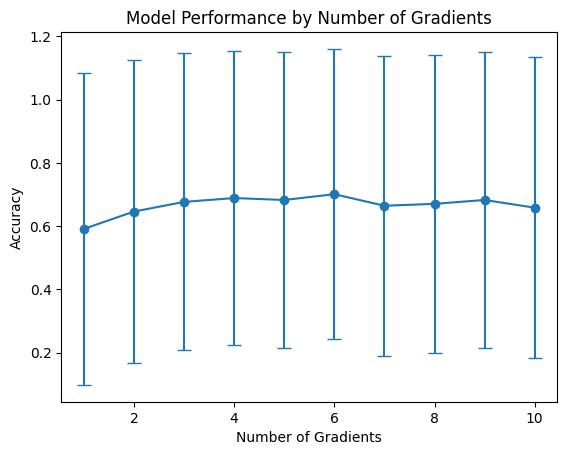

In [51]:
# group performance data by number of neighbors and calculate mean accuracy and standard deviation
grouped_data = perf_df_grads.groupby(['N_grads']).agg({'Accuracy': ['mean', 'std']}).reset_index()
grouped_data.columns = ['N_grads', 'Mean Accuracy', 'Standard Deviation']

# plot mean accuracy with error bars representing one standard deviation
plt.errorbar(grouped_data['N_grads'], grouped_data['Mean Accuracy'], yerr=grouped_data['Standard Deviation'], fmt='o-', capsize=5)

# add axis labels and title
plt.xlabel('Number of Gradients')
plt.ylabel('Accuracy')
plt.title('Model Performance by Number of Gradients')

plt.show()

# On N_neighbours

In [52]:
y_disp = np.concatenate((y_train, y_test))

In [55]:
# fit model with LOO CV

perf_df_disp = pd.DataFrame(columns = ['N_neighbours', 'Accuracy', 'Precision', 'Recall', 'F1', 'Deviance'])
dfs = []

loo = LeaveOneOut()

for n_neighbours in n_neighbours_list:
    acc_list = []
    prec_list = []
    rec_list = []
    f1_list = []
    roc_auc_list = []
    deviance_list = []
    X_disp = np.row_stack((disp_dict_train[n_neighbours], disp_dict_test[n_neighbours]))
    clf = LogisticRegression(max_iter=10000)

    for train_index, test_index in loo.split(X_disp):
        X_train_disp, X_test_disp = X_disp[train_index], X_disp[test_index]
        y_train, y_test = y_disp[train_index], y_disp[test_index]

        clf.fit(X_train_disp, y_train)

        y_prob = clf.predict_proba(X_test_disp)
        y_pred = clf.predict(X_test_disp)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, pos_label=1)
        rec = recall_score(y_test, y_pred, pos_label=1)
        f1 = f1_score(y_test, y_pred, pos_label=1)
        #roc_auc = roc_auc_score(y_test, y_prob[:, 1])

        log_likelihood_model = np.sum(y_test * np.log(y_prob[:, 1]) + (1 - y_test) * np.log(1 - y_prob[:, 1]))
        log_likelihood_saturated = np.sum(y_test * np.log(np.mean(y_test)) + (1 - y_test) * np.log(1 - np.mean(y_test)))
        deviance = -2 * (log_likelihood_model - log_likelihood_saturated)

        acc_list.append(acc)
        prec_list.append(prec)
        rec_list.append(rec)
        f1_list.append(f1)
        #roc_auc_list.append(roc_auc)
        deviance_list.append(deviance)

    perf_df_disp_temp = pd.DataFrame({
        'N_neighbours': [n_neighbours] * len(y_disp),
        'Accuracy': acc_list,
        'Precision': prec_list,
        'Recall': rec_list,
        'F1': f1_list,
        #'ROC_AUC': roc_auc_list,
        'Deviance': deviance_list
    })

    dfs.append(perf_df_disp_temp)

perf_df_disp = pd.concat(dfs, ignore_index=True)

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_4032/2535376236.py:33: RuntimeWarning:

divide by zero encountered in log

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_4032/2535376236.py:33: RuntimeWarning:

invalid value encountered in multiply

/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_4032/2535376236.py:33: RuntimeWarning:

divide by zero encountered in log

/var/folders/2m/72fcyjmd7vs3g18rkfwx7n

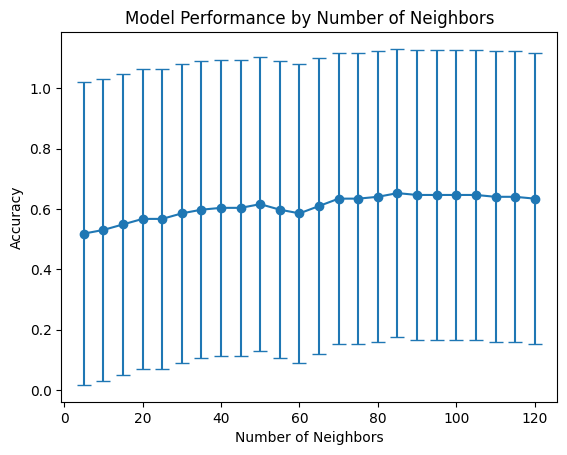

In [56]:
grouped_data = perf_df_disp.groupby(['N_neighbours']).agg({'Accuracy': ['mean', 'std']}).reset_index()
grouped_data.columns = ['N_neighbours', 'Mean Accuracy', 'Standard Deviation']

# plot mean accuracy with error bars representing one standard deviation
plt.errorbar(grouped_data['N_neighbours'], grouped_data['Mean Accuracy'], yerr=grouped_data['Standard Deviation'], fmt='o-', capsize=5)

# add axis labels and title
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Model Performance by Number of Neighbors')

plt.show()

In [57]:
grouped_data

N_neighbours  Mean Accuracy  Standard Deviation
0              5       0.518293            0.501196
1             10       0.530488            0.500598
2             15       0.548780            0.499139
3             20       0.567073            0.496998
4             25       0.567073            0.496998
5             30       0.585366            0.494168
6             35       0.597561            0.491891
7             40       0.603659            0.490635
8             45       0.603659            0.490635
9             50       0.615854            0.487882
10            55       0.597561            0.491891
11            60       0.585366            0.494168
12            65       0.609756            0.489299
13            70       0.634146            0.483144
14            75       0.634146            0.483144
15            80       0.640244            0.481399
16            85       0.652439            0.477654
17            90       0.646341            0.479569
18            95       0.646341            0.479569
19           100       0.646341            0.479569
20           105       0.646341            0.479569
21           110       0.640244            0.481399
22           115       0.640244            0.481399
23           120       0.634146            0.483144